# Understanding IDyOMpy - by Guilhem Marion
Source Repo available: https://github.com/GuiMarion/IDyOMpy/tree/master


In [6]:
# from codeForPaper-IDyOMpy-.IDyOM.idyom import idyom, data
# from codeForPaper-IDyOMpy-.IDyOM.App import Train, SurpriseOverFolder, cross_validation
import mido
import collections
import numpy as np

In [7]:
train_path = "trainingFolder/"
eval_path = "testFolder/"

# General Notes

### 1. Train Model - this function trains a model with midi files contained in the passed folder and saves it in model folder. Parameters include: 
- maxOrder: fed into idyom.idyom function as the limit of how long an n-gram (a chunk of melody) can be 
- time_representation: used in train_by_piece.. ???
- zero_padding: defaults to True ..???
- long_term_only: defaults to false meaning we use both forms of memory and pre-compute Entropy
- short_term_only: defaults to false meaning we use both forms of memory and pre-compute Entropy
- viewPoints: (options: ['pitch', 'length', 'interval', 'velocity']) what you train the model to use as features which inform the markov chain prediction 
#### a. Class idyom.idyom() - called within App.Train() and represents the entire model. Parameters include: 
- maxOrder: maximal order of the model
- viewPoints: viewPoint to use 
- stm: defaults to True meaning we will use the short term model
- evolution: defaults to False 
##### .train() - function within idyom.idyom() which trains a new LTM model based on data.getData(viewPoint) and preComputesEntropies if we are using both LTM and STM 
##### .mergeProbas() - function to merge probabilities from different models by doing a weighted average 
- probas: the probabilities you will merge
- weights: weight applied to each model's probabilities when merging into 1 average; calc'ed from normalized entropy
#### b. Class data.data() - called within idyom.idyom() constructor to train the LTM model. Parameters include: 
- quantization: defaults to 24 which is the smallest measure of rhythm, 16 meaning 1/16th of a beat
- viewpoints: described above, if none provided defaults to all 
- deleteDuplicates: if true, allows the program to delete duplicate files during training
##### .getViewpointRepresentation() - function which creates a dictionary of viewpoints where each viewpoint has a sub-array which stores the data related to that viewpoint
##### .dataToViewpoint() - function that stores a numerical representation for each viewpoint inputted based on the Midi score data into one dictionary 
- "length" = score.duration()[:-1]
- "pitch" = score.pitch
- "interval" = list of the distance between pitches in the sequence of score.pitch 
- "velocity" = score.velocity
#### c. Class Score() - a class used to convert midi data into numpy arrays
 

# Midi File Processing 

In [8]:
class Note(object):
    """A simple Note object.
    Parameters
    ----------
    velocity : int
        Note velocity.
    pitch : int
        Note pitch, as a MIDI note number.
    start : float
        Note on time, absolute, in ticks.
    end : float
        Note off time, absolute, in ticks.
    """

    def __init__(self, velocity, pitch, start, end):
        self.velocity = velocity
        self.pitch = pitch
        self.start = start
        self.end = end

    def get_duration(self):
        """Get the duration of the note in ticks."""
        return self.end - self.start

    def __repr__(self):
        return 'Note(start={:d}, end={:d}, pitch={}, velocity={})'.format(
            self.start, self.end, self.pitch, self.velocity)

In [9]:
def getNotesFromMidi(midiFile):
	"""
	Compute a list of Note objects from a midi file.
	----------
	midiFile : str
		Filepath of the midi file.

	Returns
	-------
	notes : list of Note.
		List of Note objects.
	"""

	mido_obj = mido.MidiFile(midiFile)

	# Delta to cumulative
	for track in mido_obj.tracks:
		tick = int(0)
		for event in track:
			event.time += tick
			tick = event.time
	NOTES = []
	# We extract the notes from the events
	for track_idx, track in enumerate(mido_obj.tracks):
		# Keep track of last note on location:
		last_note_on = collections.defaultdict(list)

		notes = []
		for event in track:
			if event.type == 'note_on' and event.velocity > 0:
				# Store this as the last note-on location
				note_on_index = (event.channel, event.note)
				last_note_on[note_on_index].append((
					event.time, event.velocity))
			# Note offs can also be note on events with 0 velocity
			elif event.type == 'note_off' or (event.type == 'note_on' and
											  event.velocity == 0):
				# Check that a note-on exists (ignore spurious note-offs)
				key = (event.channel, event.note)
				if key in last_note_on:
					# Get the start/stop times and velocity of every note
					# which was turned on with this instrument/drum/pitch.
					# One note-off may close multiple note-on events from
					# previous ticks. In case there's a note-off and then
					# note-on at the same tick we keep the open note from
					# this tick.
					end_tick = event.time
					open_notes = last_note_on[key]

					notes_to_close = [
						(start_tick, velocity)
						for start_tick, velocity in open_notes
						if start_tick != end_tick]
					notes_to_keep = [
						(start_tick, velocity)
						for start_tick, velocity in open_notes
						if start_tick == end_tick]

					for start_tick, velocity in notes_to_close:
						start_time = start_tick
						end_time = end_tick
						# Create the note event
						note = Note(velocity, event.note, start_time,
									end_time)
			
						notes.append(note)

					if len(notes_to_close) > 0 and len(notes_to_keep) > 0:
						# Note-on on the same tick but we already closed
						# some previous notes -> it will continue, keep it.
						last_note_on[key] = notes_to_keep
					else:
						# Remove the last note on for this instrument
						del last_note_on[key]

			elif event.type == 'end_of_track':
				# This is not more reliable than looking at the encoded duration.
				pass
		NOTES.append(notes)

	isPoly = False
	for N in NOTES:
		if len(N) > 0:
			if isPoly:
				raise RuntimeError("This file is polyphonic, I cannot handle this: "+str(midiFile))
			notes = N
			isPoly = True

	if not isPoly:
		raise RuntimeError("This file is empty, I cannnot handle this ... " + str(midiFile))

	return notes, mido_obj.ticks_per_beat


In [12]:
midiFile = "codeForPaper-IDyOMpy-/dataset/bach_Pearce/chor-183.mid"

notes, ticks_per_beat = getNotesFromMidi(midiFile)

print("Notes:", len(notes))
for note in notes:
    print("\n", note) 

print("Ticks Per Beat:", ticks_per_beat)



Notes: 47

 Note(start=72, end=96, pitch=64, velocity=100)

 Note(start=96, end=120, pitch=71, velocity=100)

 Note(start=120, end=144, pitch=68, velocity=100)

 Note(start=144, end=168, pitch=64, velocity=100)

 Note(start=168, end=192, pitch=71, velocity=100)

 Note(start=192, end=216, pitch=73, velocity=100)

 Note(start=216, end=240, pitch=73, velocity=100)

 Note(start=240, end=264, pitch=71, velocity=100)

 Note(start=264, end=288, pitch=71, velocity=100)

 Note(start=288, end=312, pitch=73, velocity=100)

 Note(start=312, end=336, pitch=75, velocity=100)

 Note(start=336, end=360, pitch=76, velocity=100)

 Note(start=360, end=384, pitch=75, velocity=100)

 Note(start=384, end=408, pitch=73, velocity=100)

 Note(start=408, end=432, pitch=73, velocity=100)

 Note(start=432, end=456, pitch=71, velocity=100)

 Note(start=456, end=480, pitch=68, velocity=100)

 Note(start=480, end=504, pitch=73, velocity=100)

 Note(start=504, end=528, pitch=71, velocity=100)

 Note(start=528, end=55

### Questions: 
- What is "ticks per beat" does this mean BPM since default tempo is 120?

# Replicating EEG Study 

In [34]:
train_path = "trainingFolder/"
eval_path = "testFolder/"
quantization = 24
maxOrder = 20
viewPoints = ["pitch", "length"]

In [ ]:
# 1. Train the model
Train(
    folder=train_path,
    quantization=quantization,
    maxOrder=maxOrder,
    viewPoints=viewPoints,
)



________ We are working on 'trainingFolder'

_____ Filling the database ...

 - trainingFolder/largeWestern_wt_bach/schweiz/suisse66.mid
 - trainingFolder/largeWestern_wt_bach/schweiz/suisse72.mid
 - trainingFolder/largeWestern_wt_bach/schweiz/suisse73.mid
 - trainingFolder/largeWestern_wt_bach/schweiz/suisse67.mid
 - trainingFolder/largeWestern_wt_bach/schweiz/suisse59.mid
 - trainingFolder/largeWestern_wt_bach/schweiz/suisse71.mid
 - trainingFolder/largeWestern_wt_bach/schweiz/suisse65.mid
 - trainingFolder/largeWestern_wt_bach/schweiz/suisse64.mid
 - trainingFolder/largeWestern_wt_bach/schweiz/suisse70.mid
 - trainingFolder/largeWestern_wt_bach/schweiz/suisse58.mid
 - trainingFolder/largeWestern_wt_bach/schweiz/suisse74.mid
 - trainingFolder/largeWestern_wt_bach/schweiz/suisse60.mid
 - trainingFolder/largeWestern_wt_bach/schweiz/suisse48.mid
 - trainingFolder/largeWestern_wt_bach/schweiz/suisse49.mid
 - trainingFolder/largeWestern_wt_bach/schweiz/suisse61.mid
 - trainingFolder/larg

In [35]:
# 2. Load model
train_name = train_path.rstrip("/").split("/")[-1]

model_path = f"models/{train_name}_quantization_{quantization}_maxOrder_{maxOrder}_viewpoints_{viewPoints[0]}_{viewPoints[1]}.model"
print(model_path)

model = idyom.idyom()
model.load(model_path)

models/trainingFolder_quantization_24_maxOrder_20_viewpoints_pitch_length.model


(array([ 5.19031694,  5.15381499,  3.16967433, ...,  6.11365279,
        6.33770388, 52.        ], shape=(1022,)), array([4.59102074, 4.47621174, 3.74961209, ..., 3.79302916, 3.02991114,
       2.25228362], shape=(1022,)))


 ...]

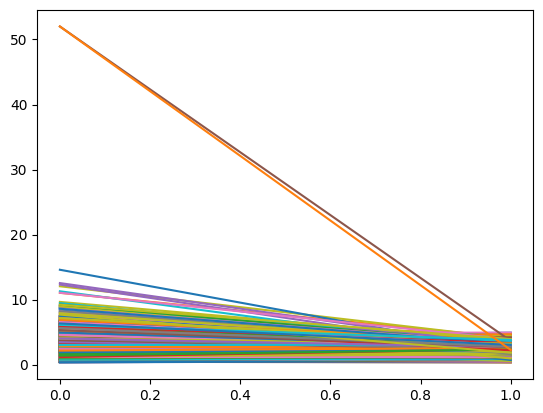

In [37]:
# 3. Surprise for a single file
IC = model.getSurprisefromFile(
    midiFile,
    genuine_entropies=False,
    short_term_only=False,
    long_term_only=False
)

print(IC)

import matplotlib.pyplot as plt

plt.plot(IC)